# IPL: Mining, Modeling and Predicting

## Dataset source

https://www.kaggle.com/manasgarg/ipl/data

## Goals

- Finding the best lineup and batting order for each team
- Predicting the winner or results of next IPL season
- Deiciding Man-of-the-Match for each match
- Creating a simulation game that simulates matches based on picked team, batting line-up chosen and bowler chosen.

## Mount Drive

You need to download those two csv files and upload them to drive on your end as well.

The below code will ask you for access to your google drive so that it can find those csv files

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import time
from game_tools import Team, Player
from simulators import SimplisticSimulator

## Preprocessing

In [2]:
deliveries_path_colab = "/content/drive/My Drive/deliveries.csv"
matches_path_colab = "/content/drive/My Drive/matches.csv"

deliveries_path_local = "data/deliveries.csv"
matches_path_local = "data/matches.csv"

colab = False

if colab:
    deliveries_path = deliveries_path_colab
    matches_path = matches_path_colab
    
    from google.colab import drive
    drive.mount('/content/drive')
    
else:
    deliveries_path = deliveries_path_local
    matches_path = matches_path_local

deliveries_df = pd.read_csv(deliveries_path)
matches_df = pd.read_csv(matches_path)

In [3]:
deliveries_df.iloc[0:5,] # iloc is a way to index the dataframe by row(s) and column(s) as you can see

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,...,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
2,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,3,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,4,0,4,NaN,NaN,NaN
3,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,4,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
4,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,5,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,2,2,NaN,NaN,NaN


In [4]:
deliveries_df.columns # These are the names of the columns you can use to index the df

Index(['match_id', 'inning', 'batting_team', 'bowling_team', 'over', 'ball',
       'batsman', 'non_striker', 'bowler', 'is_super_over', 'wide_runs',
       'bye_runs', 'legbye_runs', 'noball_runs', 'penalty_runs',
       'batsman_runs', 'extra_runs', 'total_runs', 'player_dismissed',
       'dismissal_kind', 'fielder'],
      dtype='object')

In [5]:
# Converting datatypes of columns to what they should be
deliveries_df = deliveries_df.astype({"batsman_runs":"int32",
                      "over":"int32",
                      "ball":"int32",
                      "bye_runs":"int32",
                      "noball_runs":"int32",
                      "wide_runs":"int32",
                      "penalty_runs":"int32",
                      "legbye_runs":"int32",
                      "extra_runs":"int32",
                      "total_runs":"int32"})

deliveries_df.iloc[0:12,]

,match_id,inning,batting_team,bowling_team,over,ball,batsman,non_striker,bowler,is_super_over,...,bye_runs,legbye_runs,noball_runs,penalty_runs,batsman_runs,extra_runs,total_runs,player_dismissed,dismissal_kind,fielder
0,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,1,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
1,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,2,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
2,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,3,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,4,0,4,NaN,NaN,NaN
3,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,4,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
4,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,5,DA Warner,S Dhawan,TS Mills,0,...,0,0,0,0,0,2,2,NaN,NaN,NaN
5,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,6,S Dhawan,DA Warner,TS Mills,0,...,0,0,0,0,0,0,0,NaN,NaN,NaN
6,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,1,7,S Dhawan,DA Warner,TS Mills,0,...,0,1,0,0,0,1,1,NaN,NaN,NaN
7,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,2,1,S Dhawan,DA Warner,A Choudhary,0,...,0,0,0,0,1,0,1,NaN,NaN,NaN
8,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,2,2,DA Warner,S Dhawan,A Choudhary,0,...,0,0,0,0,4,0,4,NaN,NaN,NaN
9,1,1,Sunrisers Hyderabad,Royal Challengers Bangalore,2,3,DA Warner,S Dhawan,A Choudhary,0,...,0,0,1,0,0,1,1,NaN,NaN,NaN


In [6]:
batsmen_names = set(deliveries_df["batsman"]) # list of all batsmen
batsmen_stats_dict = {}

for batter in batsmen_names:
    batter_data = deliveries_df[deliveries_df["batsman"] == batter]
    innings = len(set(batter_data["match_id"]))

    # Balls Faced = Total balls on strike - no balls - wide balls
    balls_faced = len(batter_data) - len(batter_data[batter_data["noball_runs"] > 0]) - len(batter_data[batter_data["wide_runs"] > 0]) 
    runs_scored = sum(batter_data["batsman_runs"])
    dismissals = len(deliveries_df[deliveries_df["player_dismissed"] == batter])

    run_distribution = batter_data["batsman_runs"].value_counts().to_dict()
    dismissal_distribution = batter_data[batter_data["dismissal_kind"].notna()]["dismissal_kind"].value_counts().to_dict()

    batsmen_stats_dict[batter] = {"Innings":innings,
                                  "Runs": runs_scored,
                                  "Balls Faced": balls_faced,
                                  "Dismissals": dismissals,
                                  "Run Distribution":run_distribution,
                                  "Dismissal Distribution": dismissal_distribution}

In [7]:
batsmen_df = pd.DataFrame(batsmen_stats_dict).T
batsmen_df = pd.concat([batsmen_df.drop(["Run Distribution"], axis=1), batsmen_df["Run Distribution"].apply(pd.Series)], axis=1)
batsmen_df = pd.concat([batsmen_df.drop(["Dismissal Distribution"], axis=1), batsmen_df["Dismissal Distribution"].apply(pd.Series)], axis=1)
batsmen_df.fillna(0, inplace=True)
batsmen_df = batsmen_df.astype(int)

#Renaming
batsmen_df.reset_index(inplace=True)
colnames = batsmen_df.columns.values
colnames[0] = "Name"
batsmen_df.columns = colnames

# Additional Columns
batsmen_df["Average"] = batsmen_df["Runs"] / batsmen_df["Dismissals"]
batsmen_df["Strike Rate"] = 100 * batsmen_df["Runs"] / batsmen_df["Balls Faced"]

# Display settings
    # decimal display format
pd.options.display.float_format = '{:.2f}'.format
# Note the below three columns are not actually dropped, just omitted from the display 
batsmen_df.drop(["retired hurt", "hit wicket", "obstructing the field"], axis=1).iloc[0:5, ]

,Name,Innings,Runs,Balls Faced,Dismissals,0,1,2,3,4,5,6,caught,lbw,bowled,run out,stumped,caught and bowled,Average,Strike Rate
0,JJ van der Wath,3,18,16,2,8,6,1,0,1,0,1,1,1,0,0,0,0,9.00,112.50
1,Salman Butt,7,193,160,7,86,47,7,0,30,0,2,4,2,1,0,0,0,27.57,120.62
2,Ankit Soni,3,7,9,2,7,1,0,0,0,0,1,0,0,2,0,0,0,3.50,77.78
3,Yashpal Singh,4,47,65,4,39,20,2,1,5,0,0,4,0,0,0,0,0,11.75,72.31
4,DJ Hussey,61,1322,1070,49,425,452,72,2,90,0,60,32,1,9,6,1,0,26.98,123.55


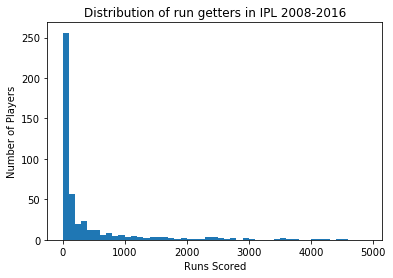

In [9]:
plt.hist(batsmen_df["Runs"], bins=np.arange(0,5000,100))
plt.xlabel("Runs Scored")
plt.ylabel("Number of Players")
plt.title("Distribution of run getters in IPL 2008-2016")
plt.show()

In [10]:
top_n = 50
high_scorers = batsmen_df.sort_values(by=["Runs"], ascending=False)
high_scorers = high_scorers.iloc[0:top_n, ] # top 50 run getters only

## Types of Batsmen: Preliminary Analysis

/Users/vijaya/miniconda2/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


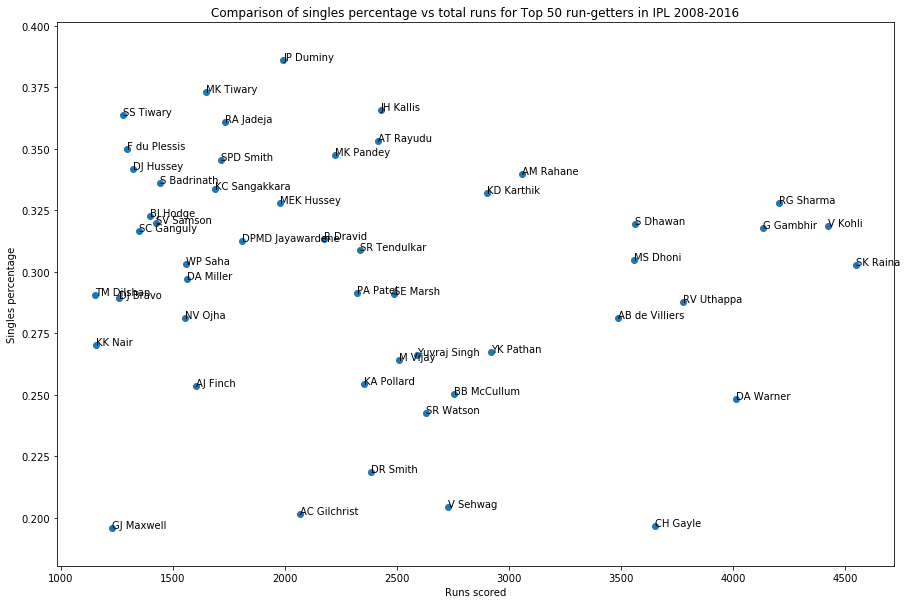

In [11]:
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(high_scorers["Runs"], high_scorers[1] / high_scorers["Runs"])
ax.set_xlabel("Runs scored")
ax.set_ylabel("Singles percentage")
ax.set_title("Comparison of singles percentage vs total runs for Top 50 run-getters in IPL 2008-2016")

for i, batter in enumerate(high_scorers["Name"]):
    ax.annotate(batter, (high_scorers["Runs"].iloc[i], high_scorers[1].iloc[i] / high_scorers["Runs"].iloc[i]))

fig.show()

As expected, Chris Gayle is on the bottom right, Virat Kohli is in the top right, and more traditional batsmen like Sangakarra are in the top left.

/Users/vijaya/miniconda2/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


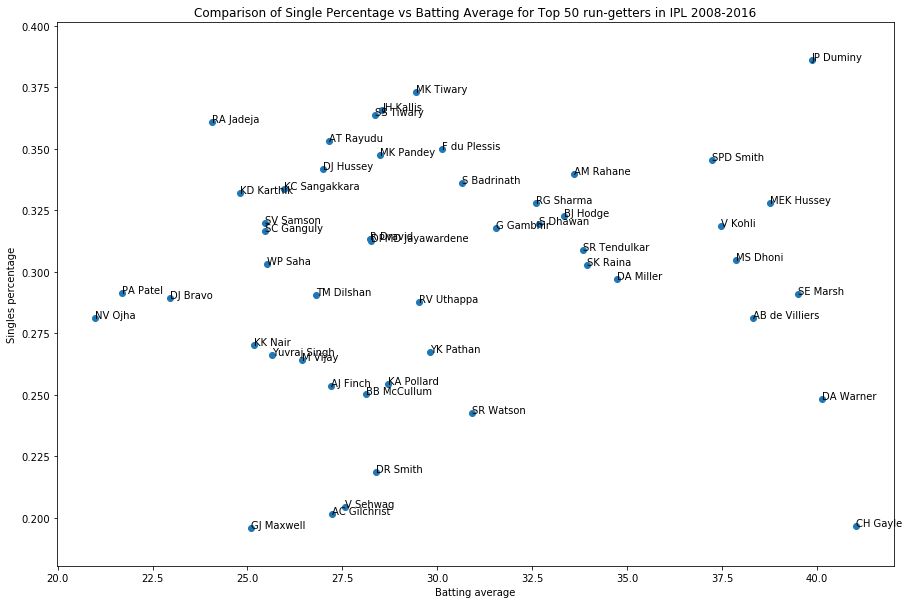

In [12]:
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(high_scorers["Average"], high_scorers[1] / high_scorers["Runs"])
ax.set_xlabel("Batting average")
ax.set_ylabel("Singles percentage")
ax.set_title("Comparison of Single Percentage vs Batting Average for Top 50 run-getters in IPL 2008-2016")

for i, batter in enumerate(high_scorers["Name"]):
    ax.annotate(batter, (high_scorers["Average"].iloc[i], high_scorers[1].iloc[i] / high_scorers["Runs"].iloc[i]))

fig.show()

This is even more prominent now as Chris Gayle is in the extreme bottom right, and accumulators like Sangakarra, Kallis or even Rayudu are on the top left. Blasters like Maxwell, Sehwag and Gilchrist are also where we expect, hovering closer to bottom left.

### Run Distributions

Piechart of run distributions

/Users/vijaya/miniconda2/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


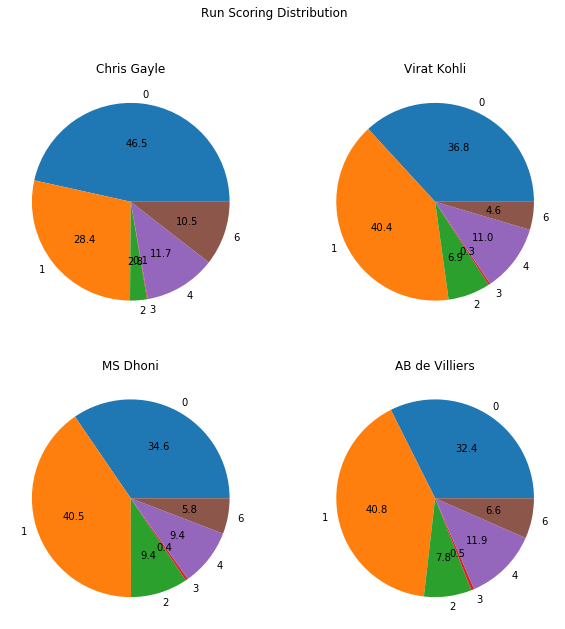

In [13]:
gayle = batsmen_stats_dict["CH Gayle"]["Run Distribution"]
kohli = batsmen_stats_dict["V Kohli"]["Run Distribution"]
dhoni = batsmen_stats_dict["MS Dhoni"]["Run Distribution"]
abd = batsmen_stats_dict["AB de Villiers"]["Run Distribution"]

order = sorted(gayle.keys())

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows = 2, ncols = 2, figsize=(10,10))
ax1.pie([v for k,v in sorted(gayle.items())], labels=[int(k) for k in order], autopct='%1.1f')
ax1.set_title("Chris Gayle")

ax2.pie([v for k,v in sorted(kohli.items())], labels=[int(k) for k in order], autopct='%1.1f')
ax2.set_title("Virat Kohli")

ax3.pie([v for k,v in sorted(dhoni.items())], labels=[int(k) for k in order], autopct='%1.1f')
ax3.set_title("MS Dhoni")

ax4.pie([v for k,v in sorted(abd.items())], labels=[int(k) for k in order], autopct='%1.1f')
ax4.set_title("AB de Villiers")

fig.suptitle("Run Scoring Distribution")
fig.show()


Notice the remarkable difference between Gayle and the rest. Gayle has significantly more dots and significantly fewer singles but has hit significantly more sixes too.

## Bowler Performance: Preliminary Analysis

In [14]:
deliveries_df.columns

Index(['match_id', 'inning', 'batting_team', 'bowling_team', 'over', 'ball',
       'batsman', 'non_striker', 'bowler', 'is_super_over', 'wide_runs',
       'bye_runs', 'legbye_runs', 'noball_runs', 'penalty_runs',
       'batsman_runs', 'extra_runs', 'total_runs', 'player_dismissed',
       'dismissal_kind', 'fielder'],
      dtype='object')

In [8]:
dismissal_kinds = set(deliveries_df['dismissal_kind'])
bowler_dismissals = ['bowled','caught','caught and bowled', 'lbw', 'stumped']

In [9]:
bowler_names = list(set(deliveries_df['bowler']))
bowler_stats_dict = {}

for bowler in bowler_names:
    bowler_data = deliveries_df[deliveries_df['bowler'] == bowler]
    
    batter_data = deliveries_df[deliveries_df["batsman"] == bowler]
    innings = set(batter_data["match_id"])
    matches = set(bowler_data["match_id"])
    matches = matches.union(innings)
    matches = len(matches)
    
    noballs = len(bowler_data[bowler_data["noball_runs"] > 0])
    wides = len(bowler_data[bowler_data["wide_runs"] > 0])

    # Total runs conceded = runs off bat + noballs + wides
    runs_conceded = np.sum(bowler_data['batsman_runs']) + np.sum(bowler_data['noball_runs']) + np.sum(bowler_data['wide_runs'])
    # Num balls = balls bowled - no balls - wides
    legal_balls_bowled = len(bowler_data) - noballs - wides
    
    dismissal_distribution = bowler_data[bowler_data["dismissal_kind"].notna()]["dismissal_kind"].value_counts().to_dict()
    wickets_taken = 0
    for bd in bowler_dismissals:
        if bd in dismissal_distribution.keys():
            wickets_taken += dismissal_distribution[bd]

    run_distribution = bowler_data["batsman_runs"].value_counts().to_dict()
    
    bowler_stats_dict[bowler] = {"Matches": matches,
                                 "Wickets": wickets_taken,
                                 "Balls Bowled": legal_balls_bowled,
                                 "Runs Conceded": runs_conceded,
                                 "Dismissal Distribution": dismissal_distribution,
                                 "Run Distribution": run_distribution,
                                 "No Balls": noballs,
                                 "Wides": wides}



In [10]:
bowlers_df = pd.DataFrame(bowler_stats_dict).T
bowlers_df = pd.concat([bowlers_df.drop(["Dismissal Distribution"], axis=1), bowlers_df["Dismissal Distribution"].apply(pd.Series)], axis=1)
bowlers_df = pd.concat([bowlers_df.drop(["Run Distribution"], axis=1), bowlers_df["Run Distribution"].apply(pd.Series)], axis=1)
bowlers_df.fillna(0, inplace=True)
bowlers_df = bowlers_df.astype(int)

#Renaming
bowlers_df.reset_index(inplace=True)
colnames = bowlers_df.columns.values
colnames[0] = "Name"
bowlers_df.columns = colnames

# Additional Columns
bowlers_df["Average"] = bowlers_df["Runs Conceded"] / bowlers_df["Wickets"]
bowlers_df["Strike Rate"] =  bowlers_df["Balls Bowled"] / bowlers_df["Wickets"]
bowlers_df["Economy"] = 6 * bowlers_df["Runs Conceded"] / bowlers_df["Balls Bowled"]


# Display settings
    # decimal display format
pd.options.display.float_format = '{:.2f}'.format
# Note the below four columns are being dropped
bowlers_df = bowlers_df.drop(["retired hurt", "hit wicket", "obstructing the field", "run out"], axis=1)
bowlers_df.iloc[0:5, ]

,Name,Matches,Wickets,Balls Bowled,Runs Conceded,No Balls,Wides,caught,lbw,stumped,...,0,1,2,3,4,5,6,Average,Strike Rate,Economy
0,JJ van der Wath,3,3,72,129,2,2,3,0,0,...,35,16,1,1,17,0,6,43.00,24.00,10.75
1,Ankit Soni,6,2,109,144,0,3,1,1,0,...,41,45,11,0,8,0,7,72.00,54.50,7.93
2,DJ Hussey,61,8,317,474,0,6,6,0,1,...,98,144,25,1,30,0,25,59.25,39.62,8.97
3,BMAJ Mendis,3,1,30,36,0,0,0,0,1,...,11,14,1,0,2,0,2,36.00,30.00,7.20
4,JW Hastings,3,3,58,66,1,2,2,0,0,...,34,13,3,0,11,0,0,22.00,19.33,6.83


In [11]:
bowlers_df[bowlers_df["Name"] == "V Kohli"]

,Name,Matches,Wickets,Balls Bowled,Runs Conceded,No Balls,Wides,caught,lbw,stumped,...,0,1,2,3,4,5,6,Average,Strike Rate,Economy
148,V Kohli,142,4,251,368,6,7,3,0,0,...,64,140,24,0,25,0,11,92.00,62.75,8.80


In [71]:
batsmen_df[batsmen_df["Name"] == "Shakib Al Hasan"]

,Name,Innings,Runs,Balls Faced,Dismissals,0,1,2,3,4,...,lbw,bowled,run out,stumped,caught and bowled,retired hurt,hit wicket,obstructing the field,Average,Strike Rate
457,Shakib Al Hasan,32,500,382,24,140,170,32,0,44,...,0,6,4,0,1,0,0,0,20.83,130.89


In [16]:
len(set(deliveries_df[deliveries_df["batsman"] == "V Kohli"]["match_id"]))

141

In [17]:
top_n = 50
wicket_takers = bowlers_df.sort_values(by=["Wickets"], ascending=False)
wicket_takers = wicket_takers.iloc[0:top_n, ] # top 50 wicket_takers only

### Top 50 Wicket Takers: Average vs Strike Rate

/Users/vijaya/miniconda2/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


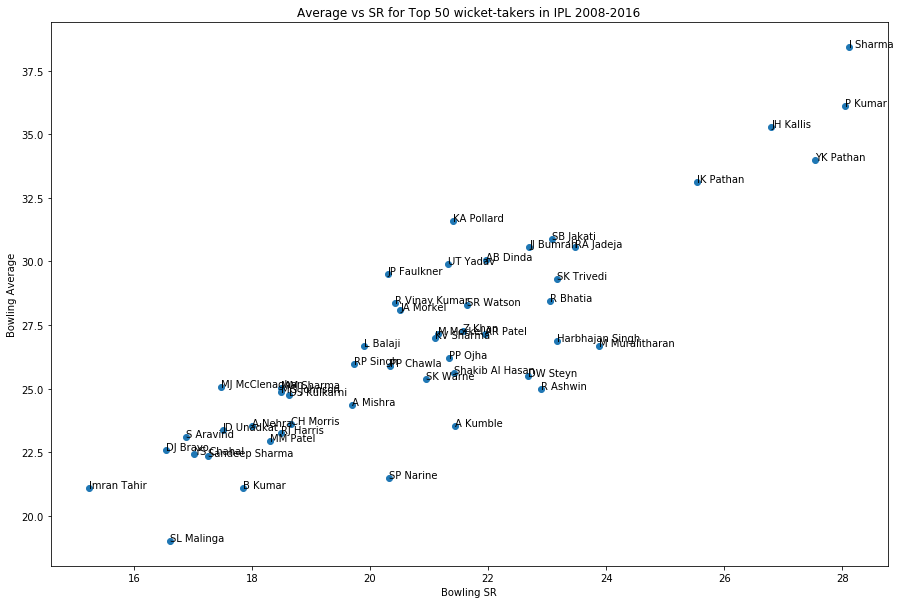

In [18]:
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(wicket_takers["Strike Rate"], wicket_takers["Average"])
ax.set_xlabel("Bowling SR")
ax.set_ylabel("Bowling Average")
ax.set_title("Average vs SR for Top 50 wicket-takers in IPL 2008-2016")

for i, bowler in enumerate(wicket_takers["Name"]):
    ax.annotate(bowler, (wicket_takers["Strike Rate"].iloc[i], wicket_takers["Average"].iloc[i]))

fig.show()

Potential for linear regression here.

### Top 50 Wicket Takers: Average vs Economy

/Users/vijaya/miniconda2/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


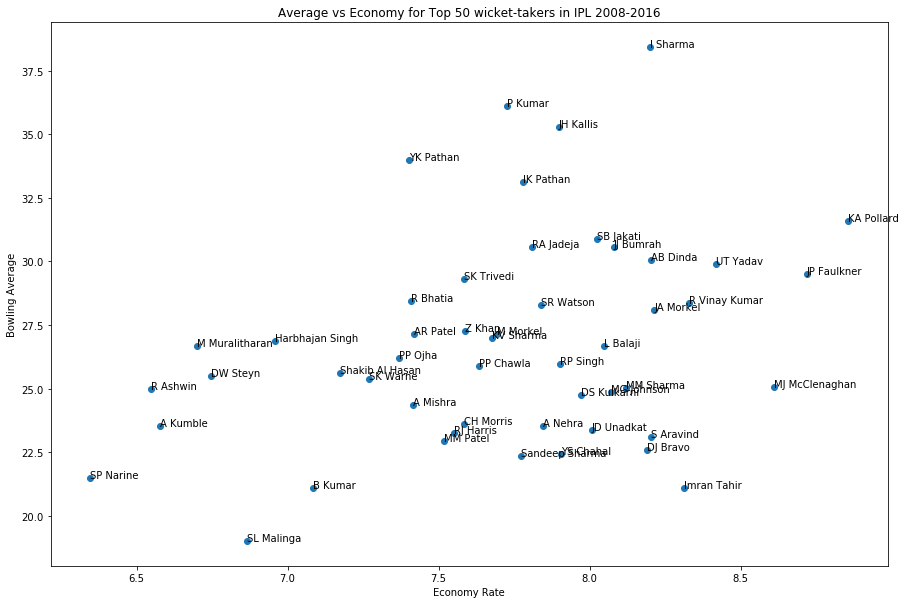

In [19]:
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(wicket_takers["Economy"], wicket_takers["Average"])
ax.set_xlabel("Economy Rate")
ax.set_ylabel("Bowling Average")
ax.set_title("Average vs Economy for Top 50 wicket-takers in IPL 2008-2016")

for i, bowler in enumerate(wicket_takers["Name"]):
    ax.annotate(bowler, (wicket_takers["Economy"].iloc[i], wicket_takers["Average"].iloc[i]))

fig.show()

### Top 50 Wicket Takers: Strike Rate vs Economy

/Users/vijaya/miniconda2/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # Remove the CWD from sys.path while we load stuff.


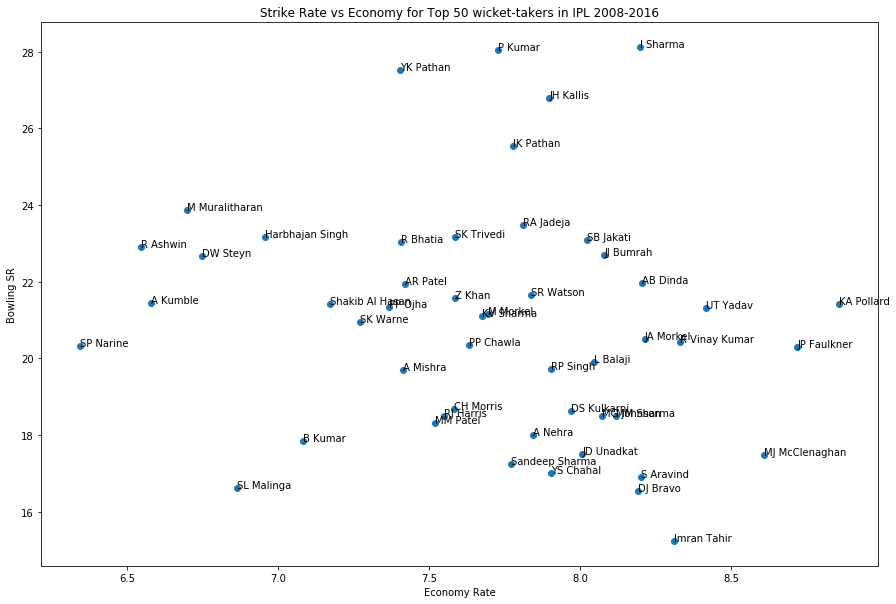

In [20]:
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(wicket_takers["Economy"], wicket_takers["Strike Rate"])
ax.set_xlabel("Economy Rate")
ax.set_ylabel("Bowling SR")
ax.set_title("Strike Rate vs Economy for Top 50 wicket-takers in IPL 2008-2016")

for i, bowler in enumerate(wicket_takers["Name"]):
    ax.annotate(bowler, (wicket_takers["Economy"].iloc[i], wicket_takers["Strike Rate"].iloc[i]))

fig.show()

In [21]:
deliveries_df[deliveries_df["fielder"].notna()]["fielder"].value_counts().iloc[0:10]

KD Karthik        127
MS Dhoni          126
RV Uthappa        115
AB de Villiers    101
SK Raina           96
PA Patel           84
NV Ojha            82
RG Sharma          79
AC Gilchrist       75
V Kohli            74
Name: fielder, dtype: int64

## Simplistic Simulator

Assume, stupidly, that everything is independent. Create joint distribution using batsman and bowler distributions for 0's to 6's.

Squads based on CSK vs RCB: IPL 2011 final

CSK:
- Michael Hussey
- Murali Vijay
- Suresh Raina
- S Badrinath
- Wriddhiman Saha
- MS Dhoni (c & wk)
- Dwayne Bravo
- Albie Morkel
- Ravichandran Ashwin
- Shadab Jakati
- Doug Bollinger


RCB: 
- Chris Gayle
- Mayank Agarwal
- Virat Kohli
- AB de Villiers (wk)
- Luke Pomersbach
- Saurabh Tiwary
- Daniel Vettori (c)
- Sreenath Aravind
- Abhimanyu Mithun
- Zaheer Khan
- JS Mohammad


In [25]:
rcb_lineup = ["CH Gayle", "MA Agarwal", "V Kohli", "AB de Villiers", "LA Pomersbach",
       "SS Tiwary", "DL Vettori", "S Aravind", "A Mithun", "Z Khan",
       "J Syed Mohammad"]
csk_lineup = ["MEK Hussey", "M Vijay", "SK Raina", "S Badrinath", "WP Saha",
       "MS Dhoni", "DJ Bravo", "JA Morkel", "R Ashwin", "SB Jakati",
       "DE Bollinger"]

prefix = "/content/drive/My Drive/IPL Simulations/Simplistic Simulations/"

rcb = Team("Royal Challengers Bangalore", rcb_lineup, abbrev="RCB", captain="DL Vettori", wk="AB de Villiers")
csk = Team("Chennai Super Kings", csk_lineup, abbrev="CSK", captain="MS Dhoni", wk="MS Dhoni")

rcb.generate_team(batsmen_df, bowlers_df)
csk.generate_team(batsmen_df, bowlers_df)

ss = SimplisticSimulator(csk, rcb)
ss.play_match(to_file=True, out_file=prefix)


hello
hello
hello
hello
hello
hello
hello
hello
hello
hello
hello


TypeError: '>=' not supported between instances of 'dict' and 'int'